In [61]:
import os
import sys
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from core.kernel import ARDKernel
import torch.optim as optim
import core.GP_CommonCalculation as GP

sys.path.append('..')  # Add parent folder to sys.path
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

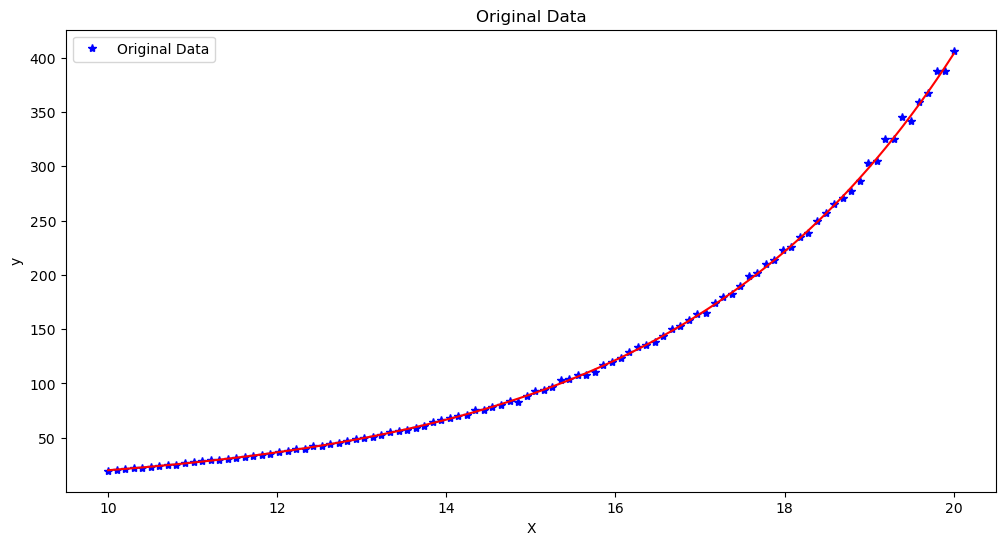

In [62]:
# Generate synthetic data
torch.manual_seed(0)
xtr = torch.linspace(10, 20, 100,dtype=torch.float64).unsqueeze(1)
# Exponential growth with multiplicative noise
ytr = torch.exp(0.3 * xtr) * (1 + 0.01 * torch.randn(xtr.size()))

# Test data
xte=torch.linspace(10, 20, 100,dtype=torch.float64).unsqueeze(1)
yte = torch.exp(0.3 * xte)
# Plot the original data
plt.figure(figsize=(12, 6))

plt.plot(xtr.numpy(), ytr.numpy(), 'b*', label='Original Data')
plt.plot(xte.numpy(),yte.numpy(),'r')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Original Data')
plt.legend()


plt.show()


In [63]:
warp=GP.Warp(method='log')
y_log=warp.transform(ytr)

In [64]:
kernel= ARDKernel(1)

In [65]:
#initiate_log_beta
log_beta = nn.Parameter(torch.ones(1) * -4) # this is a large noise. we optimize to shrink it to a proper value.

In [66]:
def negative_log_likelihood(xtr, ytr, kernel,log_beta):
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))
    return -GP.Gaussian_log_likelihood(ytr, Sigma) #you may add a loss term for the change of variable, but it is a constant term, which does not affect the optimization.

In [67]:
def forward(xtr, ytr, xte, kernel,log_beta):
    n_test = xte.size(0)

    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))

    K_s = kernel(xtr, xte)
    K_ss= kernel(xte, xte)

    mean, var = GP.conditional_Gaussian(ytr, Sigma, K_s, K_ss)

    var_diag = var.sum(dim=0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)
    return mean, var_diag

In [68]:
def train_adam(xtr, y_log, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, y_log, kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
        if (i+1)%10==0:
            print('iter', i+1, 'nll:{:.5f}'.format(loss.item()))

In [69]:
train_adam(xtr, y_log, kernel, log_beta, niteration=200,lr=0.1)

iter 10 nll:256.98564
iter 20 nll:202.00195
iter 30 nll:150.55591
iter 40 nll:100.17640
iter 50 nll:50.17124
iter 60 nll:0.51634
iter 70 nll:-48.81770
iter 80 nll:-97.75988
iter 90 nll:-146.02998
iter 100 nll:-192.76969
iter 110 nll:-235.73625
iter 120 nll:-269.93651
iter 130 nll:-288.16475
iter 140 nll:-290.59443
iter 150 nll:-289.97706
iter 160 nll:-290.73494
iter 170 nll:-290.90444
iter 180 nll:-290.87701
iter 190 nll:-290.90762
iter 200 nll:-290.91735


In [70]:
with torch.no_grad():
    ypred_log, yvar_log = forward(xtr, y_log, xte, kernel,log_beta)

In [71]:
# Back-transform
ypred,yvar=warp.back_transform(ypred_log, yvar_log)

In [76]:
#reset parameter and train the model without log transform
kernel=ARDKernel(1)
log_beta = nn.Parameter(torch.ones(1) * -4) 
train_adam(xtr, ytr, kernel, log_beta, niteration=200,lr=0.1)

iter 10 nll:7065.89510
iter 20 nll:3312.00296
iter 30 nll:2134.39280
iter 40 nll:1623.81606
iter 50 nll:1351.36681
iter 60 nll:1183.77315
iter 70 nll:1069.47322
iter 80 nll:985.61925
iter 90 nll:920.90133
iter 100 nll:869.14293
iter 110 nll:826.66982
iter 120 nll:791.13450
iter 130 nll:760.94797
iter 140 nll:734.98430
iter 150 nll:712.41653
iter 160 nll:692.62004
iter 170 nll:675.11276
iter 180 nll:659.51654
iter 190 nll:645.53119
iter 200 nll:632.91637


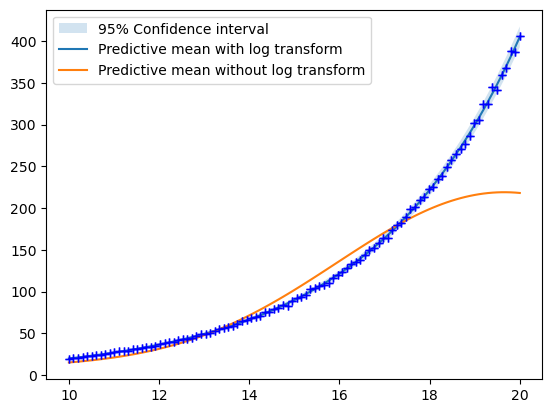

mse_log_transform: tensor(0.2878)
mse_standard: tensor(2277.7135)


In [77]:
import numpy as np
with torch.no_grad():
    ypred2, yvar2 = forward(xtr, ytr, xte, kernel,log_beta)
plt.fill_between(xte.squeeze().numpy(), ypred.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), ypred.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar.squeeze().detach().numpy()), alpha=0.2, label='95% Confidence interval')
plt.plot(xte.squeeze().numpy(), ypred.squeeze().detach().numpy(), label='Predictive mean with log transform')
plt.plot(xte.squeeze().numpy(), ypred2.squeeze().detach().numpy(), label='Predictive mean without log transform')
plt.plot(xtr.detach().numpy(), ytr.detach().numpy(), 'b+')
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.legend()
plt.show()
